In [1]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from treemind.algorithm import Explainer
from treemind.plot.plot_funcs import (
    feature_plot,
    interaction_plot,
)
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple


In [2]:
# Functions for plotting real data:
# - _set_common_style: Applies a consistent visual style to all plots to match the style used by TreeMind.
# - plot_line_chart: Creates a line chart to visualize trends in data over a continuous range.
# - plot_scatter_chart: Generates a scatter plot to explore relationships between two variables, with a third variable indicated by color.
from matplotlib.colors import TwoSlopeNorm

def _set_common_style(ax, title):
    ax.set_facecolor("whitesmoke")
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

def plot_line_chart(x, y, title, x_label, y_label, figsize: Tuple[int, int] = (10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x=x, y=y, ax=ax, color="blue", linewidth=2)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    _set_common_style(ax, title)
    plt.tight_layout()
    plt.show()

def plot_scatter_chart(x, y, z, title, x_label, y_label, figsize: Tuple[int, int] = (10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create a diverging colormap with white at zero
    norm = TwoSlopeNorm(vmin=min(z), vcenter=0, vmax=max(z))
    scatter = ax.scatter(x, y, c=z, cmap='coolwarm', norm=norm, edgecolor='k')

    # Add a colorbar for the scatter plot
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Value')

    # Set labels
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    
    # Apply common styling using _set_common_style
    _set_common_style(ax, title)

    plt.tight_layout()
    plt.show()


In [3]:
n_samples = 10000

np.random.seed(42)  # Setting a random seed for reproducibility

# Original features
# Generating synthetic data for five features:
# - feature_0, feature_1, feature_3, and feature_4 follow a normal distribution with mean 0 and standard deviation 1.
# - feature_2 is sampled from a uniform distribution between -2 and 2.

feature_0 = np.random.normal(loc=0, scale=1, size=n_samples)
feature_1 = np.random.normal(loc=0, scale=1, size=n_samples)
feature_2 = np.random.uniform(low=-2, high=2, size=n_samples)
feature_3 = np.random.normal(loc=0, scale=1, size=n_samples)
feature_4 = np.random.normal(loc=0, scale=1, size=n_samples)

# Apply complex transformations to each feature to simulate non-linear relationships.
transformed_0 = (feature_0 - 2) ** 2  # Quadratic transformation of feature_0.
transformed_1 = feature_1 * np.sin(feature_1) + 1  # Non-linear transformation using sine.
transformed_2 = np.log(np.abs(feature_2) + 1) * np.cos(feature_2)  # Logarithmic and trigonometric transformation of feature_2.
transformed_3 = np.exp(feature_3) / (1 + np.exp(-feature_3))  # Logistic sigmoid transformation.
transformed_4 = np.sqrt(np.abs(feature_4))  # Square root transformation.

# Define interactions and conditional expressions between features:
# - Interaction between transformed_0 and transformed_1: Depending on the value of transformed_0, 
#   transformed_1's effect is either positive or negative.
interaction_0_1 = np.where(transformed_0 > 1, transformed_1, -transformed_1)

# - Interaction between transformed_2 and transformed_3: This captures a multiplicative relationship.
interaction_2_3 = transformed_2 * transformed_3

# Construct the target variable:
# - Combines the interactions and transformations to create a complex relationship.
# - The coefficients (0.4, -0.6) adjust the influence of each interaction on the target.
# - Adds a small amount of Gaussian noise (mean 0, std 0.1) to simulate measurement error.

target = (
    0.4 * interaction_0_1
    - 0.6 * interaction_2_3
    + transformed_4
    + np.random.normal(loc=0, scale=0.1, size=n_samples)
)

# Create a DataFrame to hold the features and the target variable
df = pd.DataFrame(
    {
        "feature_0": feature_0,
        "feature_1": feature_1,
        "feature_2": feature_2,
        "feature_3": feature_3,
        "feature_4": feature_4,
        "target": target,
    }
)

# Split the data into features (X) and target (y)
X = df.drop("target", axis=1).values
y = df["target"].values

# Notes:
# - Feature 4 (transformed_4) is used directly in the target, while interactions occur between features 1 and 2 as well as features 3 and 4.
# - This setup allows for testing the ability of the Treemind model to detect both individual feature effects and feature interactions.


In [4]:
# Train a LightGBM model
reg = LGBMRegressor(verbose=-1)  # Instantiate the LightGBM regressor.
# - 'verbose=-1' suppresses the training output to avoid cluttering the console.

reg.fit(X, y)  # Train the model using the generated feature matrix X and target y.

# Use Treemind's Explainer to analyze the trained model
explainer = Explainer()  # Instantiate the Explainer from Treemind, which will provide model interpretability functions.
explainer(reg)  # Pass the trained LightGBM model to the Explainer to prepare it for explaining the model's predictions.
# - This step sets up the Explainer to analyze feature importance, interactions, and their impact on the model's output.


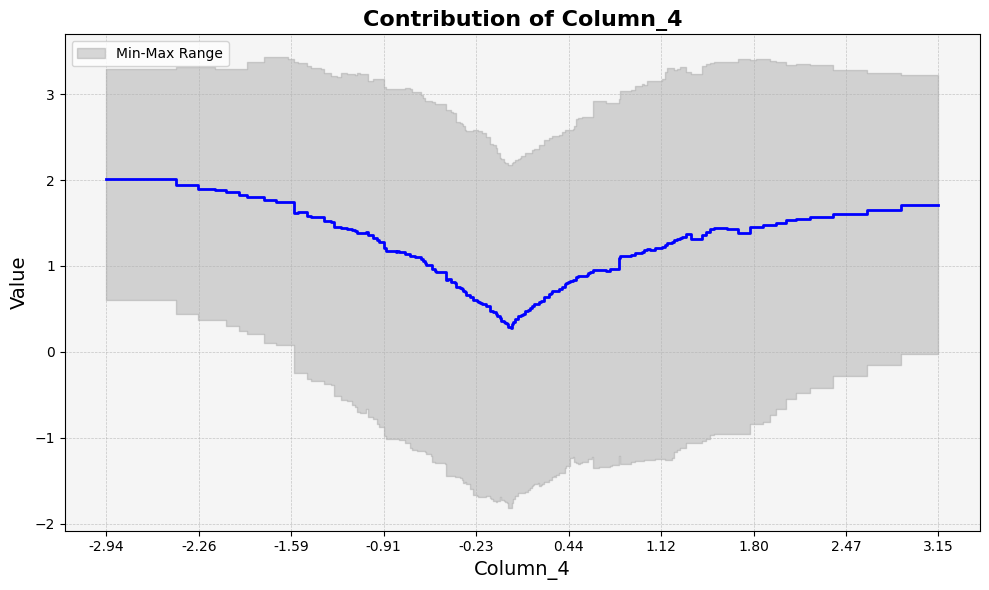

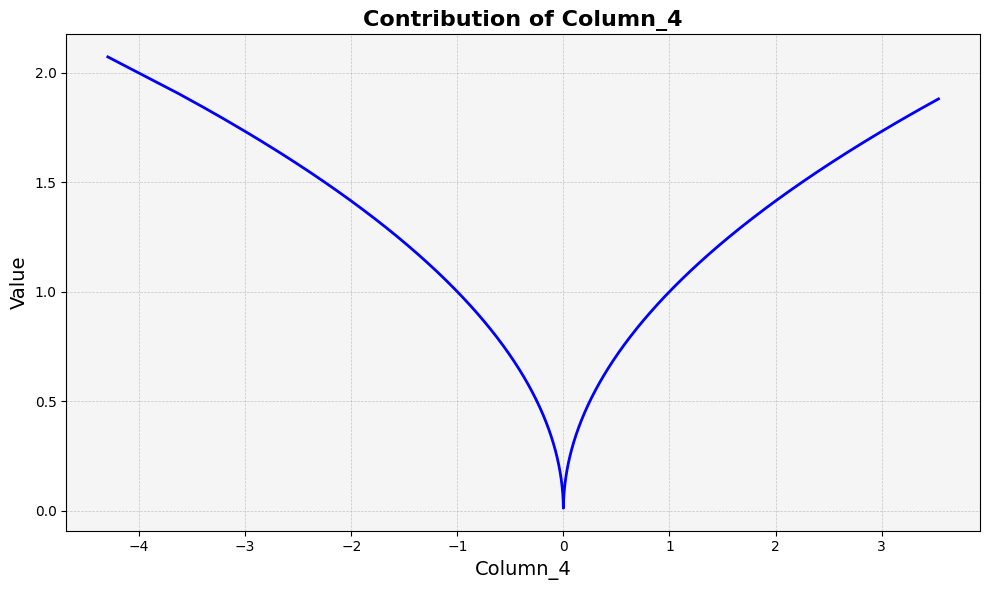

In [5]:
feature_df = explainer.analyze_feature(4)  # Analyze the effect of feature_4 using Treemind's Explainer.
# - This step evaluates how feature_4 influences the model's predictions, capturing its contribution to the target variable.

feature_plot(feature_df)  # Plot the results of the feature analysis using Treemind's feature_plot.
# - This plot shows the model's interpretation of the relationship between feature_4 and the target.

plot_line_chart(x=feature_4, y=transformed_4, x_label="Column_4", y_label="Value", title="Contribution of Column_4")  # Plot the actual relationship between the original feature_4 and the transformed version used in the target.
# - This line chart represents the true relationship used during data generation.

# As seen, the real line chart and the interpretation from Treemind's model are very similar.
# - This indicates that Treemind was able to accurately capture the single-variable relationship of feature_4 with the target.
# - The model effectively identified the direct effect of feature_4, demonstrating Treemind's capability to detect and explain individual feature contributions.


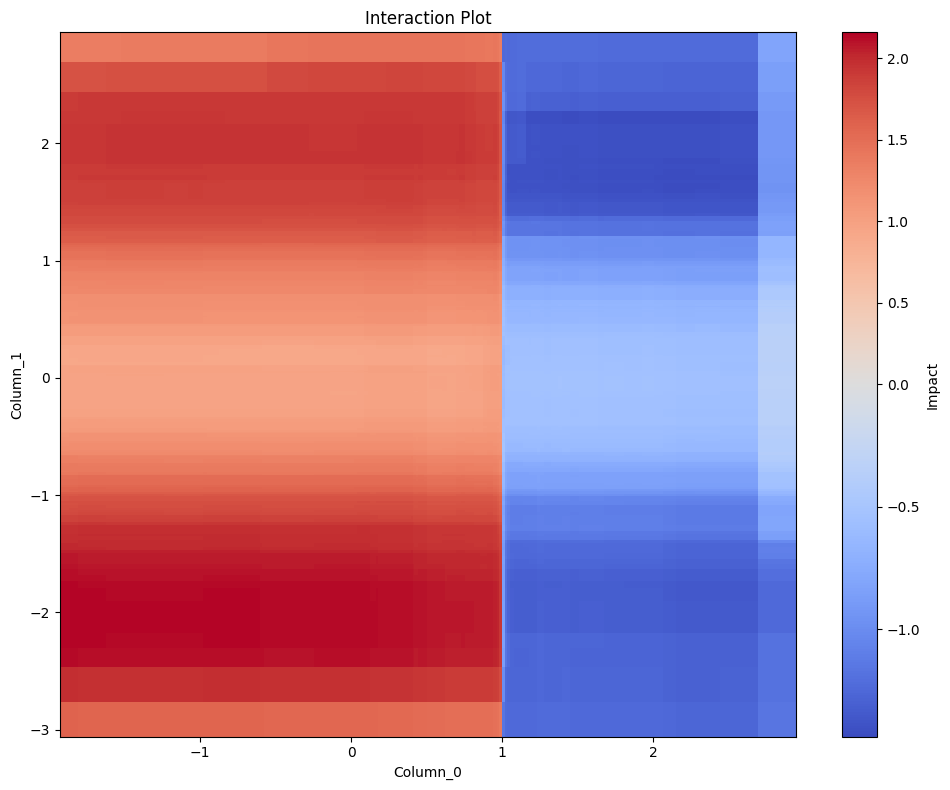

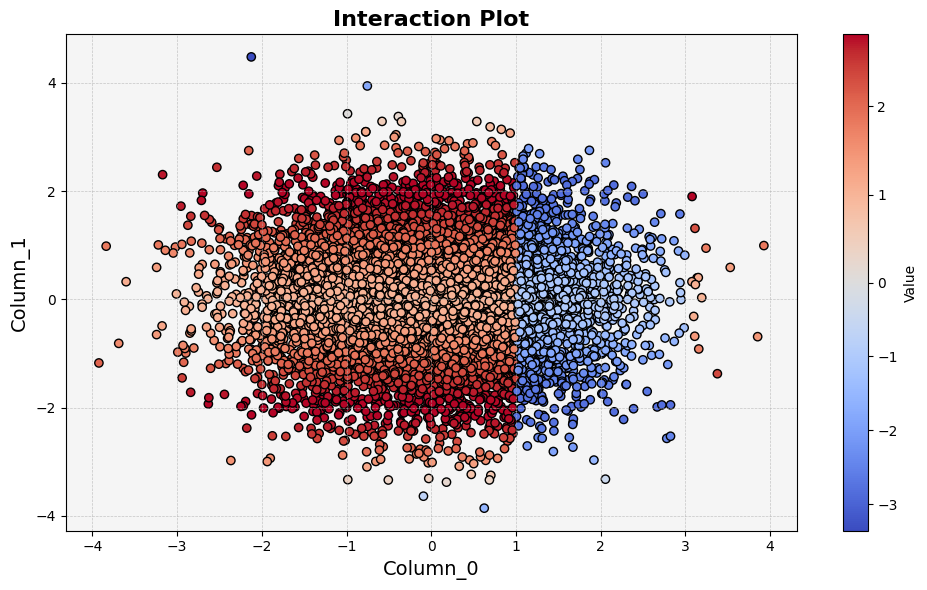

In [7]:
df = explainer.analyze_interaction(0, 1)  # Analyze the interaction between feature_0 and feature_1 using Treemind's Explainer.
# - This step evaluates how the interaction between these two features influences the model's predictions.

interaction_plot(df)  # Plot the interaction analysis results using Treemind's interaction_plot.
# - The plot visualizes the combined effect of feature_0 and feature_1 on the target variable as interpreted by the model.

plot_scatter_chart(feature_0, feature_1, interaction_0_1, x_label="Column_0", y_label="Column_1", title="Interaction Plot")  # Plot the actual relationship between feature_0, feature_1, and their interaction.
# - This scatter plot represents the true interaction effect used during data generation.

# The Treemind interaction plot closely matches the real scatter plot.
# - This indicates that Treemind successfully identified the two-way relationship between feature_0 and feature_1.
# - The model was able to detect and explain the combined effect, showing that Treemind can effectively capture complex interactions between features.


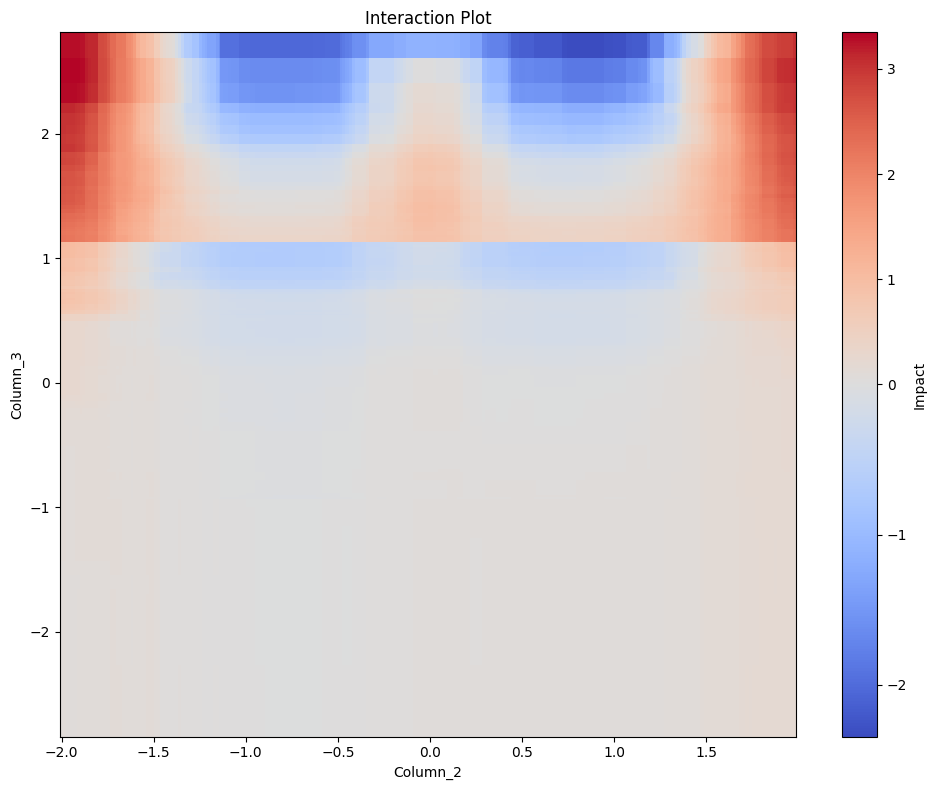

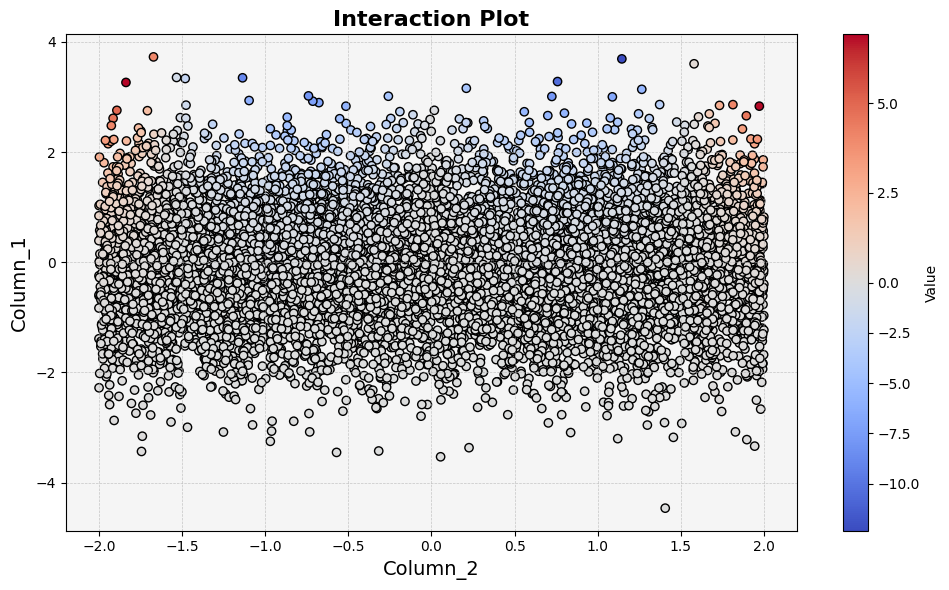

In [8]:
df = explainer.analyze_interaction(2, 3)  # Analyze the interaction between feature_2 and feature_3 using Treemind's Explainer.
# - This step evaluates how the combined effect of feature_2 and feature_3 influences the model's predictions.

interaction_plot(df)  # Plot the interaction analysis results using Treemind's interaction_plot.
# - The plot visualizes how the interaction between these features impacts the target, according to the model.

plot_scatter_chart(feature_2, feature_3, -interaction_2_3, x_label="Column_2", y_label="Column_1", title="Interaction Plot")  # Plot the actual relationship between feature_2, feature_3, and their interaction.
# - The scatter plot shows the true effect used in data generation, with a negative interaction term.

# As with the previous example, the Treemind interaction plot aligns closely with the actual scatter plot.
# - This demonstrates that Treemind accurately captured the two-way interaction between feature_2 and feature_3.
# - The model successfully detected the relationship, even with the more complex negative interaction term.
# - This further confirms Treemind's ability to handle and explain non-linear interactions in the data.


Treemind evaluates features by considering their global impact rather than isolating them in their individual or interaction effects. When analyzing the interaction between feature 1 and feature 2, Treemind takes into account the broader context, including other interactions involving feature 1 and feature 2. It assesses how these two features interact while considering their relationships with the rest of the features. Similarly, when evaluating a single feature, Treemind does not isolate its effect but instead looks at how it influences the model's predictions within the context of the overall feature set. This approach allows for a more comprehensive understanding of feature importance and interactions.